## Prepare environment

In [ ]:
import os

ORIGINAL_DIRECTORY = None

def prepare_env():
    global ORIGINAL_DIRECTORY
    if ORIGINAL_DIRECTORY is None:
        ORIGINAL_DIRECTORY = os.getcwd()
    %cd {ORIGINAL_DIRECTORY}
    running_locally = os.path.isfile('./python-code')
    if not running_locally:
        if not os.path.isdir('./voxel-nn'):
            !git clone -b dev https://github.com/Sotakebk/voxel-nn.git
        %cd ./voxel-nn/Python
        !git pull
    
    %pip install -r ./requirements.txt
    %load_ext autoreload
    %autoreload 2
prepare_env()

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

import tensorflow as tf
from voxelnn import tensorflow_tools as tft
import os

if tft.maybe_use_tpu() is False:
    gpu = tf.config.list_physical_devices('GPU')
    print(gpu)

## Settings

In [175]:
# for demo'ing and testing
shared_model_path = 'simple-terrain-2d-16x16'

files_to_load = [
    'simple-terrain-2d-16x16-dataset.json'
]

In [ ]:
# for real evaluation
shared_model_path = 'simple-enriched-terrain-2d-32x32'

files_to_load = [
    'simple-enriched-terrain-2d-1000-32x32.json'
]

## Prepare and preview dataset

In [ ]:
from voxelnn import dataset_manipulation as dm

files_to_load = [f'../Dataset/{filename}' for filename in files_to_load]

tag_names, block_names, entry_names, tags_multilabel, blocks = dm.load_dataset(files_to_load)
print(f'Blocks: {block_names} ({len(block_names)})')
print(f'Tags: {tag_names} ({len(tag_names)})')
print(f'Data shape: {blocks.shape}')

In [ ]:
import seaborn as sns

tag_cooccurence_matrix, matrix_labels = dm.cooccurence_matrix(tags_multilabel, tag_names)
_ = sns.heatmap(data=tag_cooccurence_matrix, vmin=0, annot=True, xticklabels=matrix_labels, yticklabels=matrix_labels, fmt='.5g')

In [ ]:
import numpy as np
import seaborn as sns

unique, counts = np.unique(blocks, return_counts=True)

ax = sns.barplot(x=[block_names[u] for u in unique], y=counts)
_ = ax.set_title("Occurence of block types in the dataset.")

In [ ]:
import voxelnn.jupyter_tools as jt

jt.render_some_data(blocks[:16,...])

## Shared variables

In [ ]:
real_dims = len(blocks.shape)-1 # 2D or 3D
block_type_count = len(block_names) # number of separate classes
latent_dims = 2 #int(block_type_count**0.5) # how many dimensions to encode the block types in
print(f'real dimensions in data: {real_dims}')
print(f'block types in data: {block_type_count}')
print(f'latent dimensions to encode blocks in: {latent_dims}')

## Encoders

#### Code

In [ ]:
import tensorflow as tf
import keras
from keras import layers
from voxelnn.coding.custom_layers import OneHot, Sampling

is3d = real_dims == 3

def _conv(filters: int, kernel_size=1, activation='elu', padding='same', kernel_initializer='glorot_normal', **kwargs):
    def apply(x):
        if is3d:
            return layers.Conv3D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer, **kwargs)(x)
        else:
            return layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer, **kwargs)(x)
    return apply

def _encoder_input():
    def apply():
        if is3d:
            return layers.Input(shape=(None, None, None), dtype='uint8', name='encoder_input')
        else:
            return layers.Input(shape=(None, None), dtype='uint8', name='encoder_input')
    return apply()

def _decoder_input(latent_dimensions):
    def apply():
        if is3d:
            return layers.Input(shape=(None, None, None, latent_dimensions), name='decoder_input')
        else:
            return layers.Input(shape=(None, None, latent_dimensions), name='decoder_input')
    return apply()

def create_encoder(block_type_count, latent_dimensions):
    input = _encoder_input()
    oh = OneHot(block_type_count)(input)
    c1  = _conv(filters=40, kernel_size=1, padding='same', activation='elu', kernel_initializer='glorot_normal')(oh)
    c2  = _conv(filters=30, kernel_size=1, padding='same', activation='elu', kernel_initializer='glorot_normal')(c1)
    c3  = _conv(filters=20, kernel_size=1, padding='same', activation='elu', kernel_initializer='glorot_normal')(c2)
    mean = _conv(filters=latent_dimensions, kernel_size=1, padding='same', activation='linear', name='mean')(c2)
    var = _conv(filters=latent_dimensions, kernel_size=1, padding='same', activation='linear', kernel_initializer='zeros', name='var')(c3)
    z = Sampling(name='encoder_output')([mean, var])
    encoder = keras.Model(input, [mean, var, z], name="encoder")
    return encoder

def create_decoder(block_type_count, latent_dimensions):
    input = _decoder_input(latent_dimensions)
    c1 = _conv(filters=20, kernel_size=1, padding='same', activation='elu')(input)
    c2 = _conv(filters=30, kernel_size=1, padding='same', activation='elu')(c1)
    c3 = _conv(filters=40, kernel_size=1, padding='same', activation='elu')(c2)
    c4 = _conv(block_type_count, kernel_size=1, padding='same', activation='linear', name='decoder_output')(c3)
    sm = layers.Softmax(axis=(4 if is3d else 3))(c4)
    decoder = keras.Model(input, sm, name="decoder")
    return decoder

### VAE

#### Declaration

In [ ]:
from voxelnn.coding import VAE
from voxelnn import filter_kernels as fk

vae_encoder = create_encoder(block_type_count, latent_dims)
vae_decoder = create_decoder(block_type_count, latent_dims)
vae_encoder.compile()
vae_decoder.compile()
vae = VAE.VAETrainer(vae_encoder, vae_decoder, kld_loss_weight=0.1, str_loss_weight=0.1)
vae.compile()
encoder = vae_encoder
decoder = vae_decoder

#### Training

In [ ]:
from voxelnn import jupyter_tools as jt
split = int(0.9 * blocks.shape[0])

print(f'training on {split} entries')

history = vae.fit(blocks[:split,...], epochs=100, validation_data=(blocks[split:,...], None))

jt.plot_history(history)

#### Save/Load

In [ ]:
from voxelnn import jupyter_tools as jt

jt.save_model(shared_model_path, "vae_encoder.keras", vae_encoder)
jt.save_model(shared_model_path, "vae_decoder.keras", vae_decoder)

In [ ]:
from voxelnn import jupyter_tools as jt

vae_encoder = jt.load_model(shared_model_path, "vae_encoder.keras")
vae_decoder = jt.load_model(shared_model_path, "vae_decoder.keras")
encoder = vae_encoder
decoder = vae_decoder

### SAE

#### Declaration

In [ ]:
from voxelnn.coding import SAE
from voxelnn import filter_kernels as fk

sae_encoder = create_encoder(block_type_count, latent_dims)
sae_decoder = create_decoder(block_type_count, latent_dims)
sae_encoder.compile()
sae_decoder.compile()

sae = SAE.SAETrainer(sae_encoder, sae_decoder,
                     filter_array=fk.create_kernel(3, real_dims, latent_dims),
                     kld_loss_weight=0.1,
                     str_loss_weight=0.1
                     )

sae.compile()

#### Training

In [ ]:
from voxelnn import jupyter_tools as jt
split = int(0.9 * blocks.shape[0])

print(f'training on {split} entries')

history = sae.fit(blocks[:split,...], epochs=100, validation_data=(blocks[split:,...], None))

jt.plot_history(history)

#### Save/Load

In [ ]:
from voxelnn import jupyter_tools as jt

jt.save_model(shared_model_path, "sae_encoder.keras", sae_encoder)
jt.save_model(shared_model_path, "sae_decoder.keras", sae_decoder)

In [ ]:
from voxelnn import jupyter_tools as jt

sae_encoder = jt.load_model(shared_model_path, "sae_encoder.keras")
sae_decoder = jt.load_model(shared_model_path, "sae_decoder.keras")
encoder = sae_encoder
decoder = sae_decoder

### Peek latent space from current encoder

In [ ]:
import voxelnn.jupyter_tools as jt

jt.peek_encoding_and_decoding(blocks, encoder, decoder, samples=10)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[[[-0.2100039  -0.07968065]]]


 [[[-0.17322017  0.4523244 ]]]


 [[[ 0.43939525 -0.11284319]]]


 [[[ 0.40531626  0.45767447]]]]
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


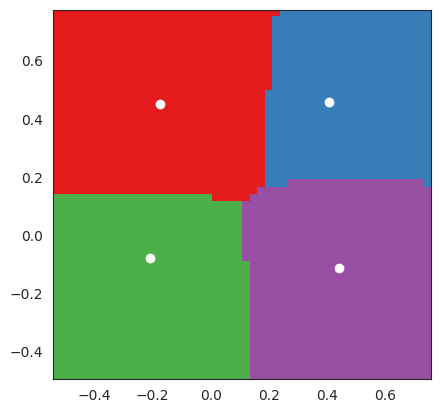

In [176]:
import numpy as np
import matplotlib.pyplot as plt

def peek_latent_space(encoder, decoder, blocks, block_type_count):
    z_mean, z_var, z = encoder.predict(blocks)
    distinct_block = np.arange(block_type_count).reshape(block_type_count, 1, 1)
    poles, _, _ = encoder.predict(distinct_block)
    print(poles)
    poles_x = poles[...,0].reshape(block_type_count)
    poles_y = poles[...,1].reshape(block_type_count)
    steps = 50
    min_x = np.min(z[...,0])
    min_y = np.min(z[...,1])
    max_x = np.max(z[...,0])
    max_y = np.max(z[...,1])
    x = np.linspace(min_x, max_x, num=steps)
    y = np.linspace(min_y, max_y, num=steps)
    XY = np.meshgrid(x,y)
    XY = np.array(XY).transpose()
    XY = XY.reshape(steps*steps, 1, 1, 2)
    decoded = decoder.predict(XY)
    real = np.argmax(decoded, axis=-1)
    real = real.reshape(steps, steps)
    colors_local = np.array(mpl.colormaps['Set1'].colors)
    colored_real = colors_local[real]
    plt.figure()
    ax = plt.imshow(colored_real, extent=[min_x, max_x, min_y, max_y])
    plt.scatter(x=poles_x, y=poles_y, color='white')

peek_latent_space(encoder, decoder, blocks, block_type_count)

## Diffusion

### Declaration

In [ ]:
from voxelnn.diffusion import unet_builder

layer_base_units = 32

unet = unet_builder.build_model(input_shape=blocks.shape[1:],
                          latent_dims=latent_dims,
                          layer_units=[a * layer_base_units for a in [1, 2, 3, 4]],
                          layer_attn_heads=[0, 1, 2, 2],
                          layer_res_blocks=[1, 1, 1, 1],
                          norm_groups=4,
                          first_conv_channels=48,
                          time_embedding_dims=32,
                          max_time_emb_frequency=200.0)
unet.compile()

In [ ]:
from voxelnn.diffusion.diffusion_model import DiffusionModel
import keras

diffusion_model = DiffusionModel(unet)
diffusion_model.compile(
        optimizer=keras.optimizers.AdamW(
        learning_rate=1e-3, weight_decay=1e-4
    ),
    loss=keras.losses.mean_absolute_error,
)

### Training

#### Prepare dataset

In [ ]:
def get_training_data(repeats):
    with_flip = np.concatenate([blocks, np.flip(blocks, axis=1)], axis=0)
    repeated = np.repeat(with_flip, repeats, axis=0)
    z_mean, _, z = encoder.predict()
    return z_mean, z

z_mean, z = get_training_data(repeats=10)

#### Actual training

##### Training - distribution from Z, data from Z_mean

In [ ]:
diffusion_model.learn_data_distribution(z)

In [ ]:
### train using only pole data
history = diffusion_model.fit(z_mean, epochs=100)

jt.plot_history(history)

##### Training - distribution from Z, data from Z

In [ ]:
diffusion_model.learn_data_distribution(z)

In [ ]:
### train using only pole data
history = diffusion_model.fit(z, epochs=100)

jt.plot_history(history)

### Save/Load

In [ ]:
import voxelnn.jupyter_tools as jt

jt.save_model(shared_model_path, "unet.keras", unet)

In [ ]:
import voxelnn.jupyter_tools as jt

unet = jt.load_model(shared_model_path, "unet.keras")

In [ ]:
import voxelnn.jupyter_tools as jt

jt.save_model(shared_model_path, "diffusion.keras", diffusion_model)

In [ ]:
import voxelnn.jupyter_tools as jt

diffusion_model = jt.load_model(shared_model_path, "diffusion.keras")

### Evaluation

In [ ]:
pred_data, pred_data_history, pred_noises_history, noisy_data_history = \
    diffusion_model.generate(diffusion_steps=12, element_count=10, method='EXPERIMENTAL')

In [ ]:
import voxelnn.jupyter_tools as jt

jt.render_all_predictions(pred_data, decoder)

In [ ]:
import voxelnn.jupyter_tools as jt

jt.render_data_history_and_other_stuff(pred_data_history, decoder, index = 0)

In [ ]:
import voxelnn.jupyter_tools as jt

jt.preview_distribution_over_time(pred_data_history, pred_noises_history)

In [ ]:
import json
import keras
import numpy as np
import voxelnn.dataset_manipulation as dm

def decode_many_to_json(latent_data: np.ndarray, decoder: keras.Model, name_pattern: str = None):
    elements = latent_data.shape[0]
    name_pattern = name_pattern or f"Unnamed element ({{}}/{elements})"
    
    entry_list = []
    decoded = decoder.predict(latent_data)
    real = np.argmax(decoded, axis=-1)

    for i in range(elements):
        entry = dm.construct_entry_dto(
            str.format(name_pattern, i+1),
            tag_names,
            np.zeros(len(tag_names)),
            block_names,
            real[i,:])
        entry_list.append(entry)
    return json.dumps(entry_list)

In [ ]:
import voxelnn.jupyter_tools as jt

print("result:")
voxels_result = decode_many_to_json(pred_data, decoder)
jt.result_json_widget(voxels_result)